In [2]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [3]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, fft

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')
plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif",
})

In [4]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

xlabel_kwargs = {"fontsize":15}
ylabel_kwargs = {"fontsize":15}
legend_kwargs = {"fontsize":12}
title_kwargs = {"fontsize":18}

In [5]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [6]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [7]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_cdv


In [8]:
from tools.ae_v2 import Autoencoder

In [9]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

if colab_flag == False:
    if strategy is None:
#         if gpus:
#             gpu_to_use = 1
        tf.config.set_visible_devices([], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[]


2023-08-06 16:36:48.795181: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:36:48.854303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:36:48.854574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-06 16:36:48.855628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
2.8.1


# KS System

In [11]:
prng_seed = 42
np.random.seed(prng_seed)

train_split = 0.8
val_split = 0.1
test_split = 0.1

In [12]:
from numpy import *

data_dir_idx = '004'

dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

fl = np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True)
all_data_og = fl['all_data'].astype(FTYPE)
boundary_idx_arr = fl['boundary_idx_arr']
normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
initial_t0 = fl['initial_t0']
init_state_mat = fl['init_state_mat']

lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

num_params = params_mat.shape[1]
og_vars = all_data_og.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

normalize_flag_ogdata: False


In [13]:
num_train = int(all_data_og.shape[0]*train_split)
num_val = int(all_data_og.shape[0]*val_split)
num_test = all_data_og.shape[0] - num_train - num_val

idx = np.arange(all_data_og.shape[0])
# np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data_og.shape[1:]), dtype=FTYPE)

training_data[:] = all_data_og[idx[0:num_train]]
val_data[:] = all_data_og[idx[num_train:num_train+num_val]]
testing_data[:] = all_data_og[idx[num_train+num_val:]]

In [14]:
print('training_data.shape : ', training_data.shape)
print('val_data.shape : ', val_data.shape)
print('testing_data.shape : ', testing_data.shape)

training_data.shape :  (400000, 6)
val_data.shape :  (50000, 6)
testing_data.shape :  (50001, 6)


In [15]:
# training data
FourierCoeffs_trainingdata = fft.fft(training_data[:, 0:og_vars], axis=1)
energySpectrum_og_trainingdata = FourierCoeffs_trainingdata.real**2 + FourierCoeffs_trainingdata.imag**2
energySpectrum_og_trainingdata = np.mean(energySpectrum_og_trainingdata, axis=0)

# testing data
FourierCoeffs_testingdata = fft.fft(testing_data[:, 0:og_vars], axis=1)
energySpectrum_og_testingdata = FourierCoeffs_testingdata.real**2 + FourierCoeffs_testingdata.imag**2
energySpectrum_og_testingdata = np.mean(energySpectrum_og_testingdata, axis=0)

In [16]:
# training data
meancentereddata_og_trainingdata = training_data[:, 0:og_vars] - np.mean(training_data[:, 0:og_vars], axis=0)
covmat_og_trainingdata = np.matmul(meancentereddata_og_trainingdata.transpose(), meancentereddata_og_trainingdata) / (meancentereddata_og_trainingdata.shape[0] - 1)
eigvals_og_trainingdata = np.abs(np.linalg.eigvals(covmat_og_trainingdata))
eigvals_og_trainingdata = np.sort(eigvals_og_trainingdata)
eigvals_og_trainingdata = eigvals_og_trainingdata[::-1]

# testing data
meancentereddata_og_testingdata = testing_data[:, 0:og_vars] - np.mean(testing_data[:, 0:og_vars], axis=0)
covmat_og_testingdata = np.matmul(meancentereddata_og_testingdata.transpose(), meancentereddata_og_testingdata) / (meancentereddata_og_testingdata.shape[0] - 1)
eigvals_og_testingdata = np.abs(np.linalg.eigvals(covmat_og_testingdata))
eigvals_og_testingdata = np.sort(eigvals_og_testingdata)
eigvals_og_testingdata = eigvals_og_testingdata[::-1]

In [17]:
# training data
print('eigvals sum (training data) : ', np.sum(eigvals_og_trainingdata))
print('FC sum (training data) : ', np.sum(energySpectrum_og_trainingdata))

# testing data
print('\neigvals sum (testing data) : ', np.sum(eigvals_og_testingdata))
print('FC sum (testing data) : ', np.sum(energySpectrum_og_testingdata))

eigvals sum (training data) :  0.07018877898757248
FC sum (training data) :  7.106307558299626

eigvals sum (testing data) :  0.07197701
FC sum (testing data) :  7.02465410819919


In [18]:
dir_name_all_ae = os.getcwd()+'{ds}saved_ae'.format(ds=dir_sep)
# dir_contents_list = os.listdir(dir_name_all_ae)
# chosen_dir_list = []
# for elem in dir_contents_list:
#     dir_name_ae = dir_name_all_ae + dir_sep + elem
#     if os.path.isdir(dir_name_ae):
#         with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
#             lines = f.readlines()
#             params_dict = eval(''.join(lines))
#             if data_dir_idx == params_dict['data_dir_idx']:
#                 chosen_dir_list.append(elem)

chosen_dir_list = [
    'ae_005',
    'ae_006',
    'ae_007',
    'ae_008',
]
print('chosen_dir_list:', chosen_dir_list)

chosen_dir_list: ['ae_005', 'ae_006', 'ae_007', 'ae_008']


In [19]:
# making AR-RNN save directory
dir_name_aepod = os.getcwd() + dir_sep + 'saved_ae/ae_pod'
if not os.path.isdir(dir_name_aepod):
    os.makedirs(dir_name_aepod)

counter = 0
while True:
    dir_check = 'ae_pod_' + str(counter).zfill(3)
    if os.path.isdir(dir_name_aepod + dir_sep + dir_check):
        counter += 1
    else:
        break

dir_name_aepod = dir_name_aepod + dir_sep + dir_check
os.makedirs(dir_name_aepod)

dir_name_plot = dir_name_aepod+dir_sep+'plots'
os.makedirs(dir_name_plot)

In [20]:
print(dir_name_aepod)

/home/rkaushik/Documents/Thesis/MLROM/new_cdv/saved_ae/ae_pod/ae_pod_007


In [21]:
num_latent_states_list = []

timeAvgEnergySpectrum = []
covmat_list_AE = []
eigvals_list_AE = []
latent_states_covmat_list = []
latent_states_eigenvals_list = []

AE_recon_MSE_lst = []
AE_recon_RMSE_lst = []
AE_recon_NMSE_lst = []
AE_recon_NRMSE_lst = []

for elem in chosen_dir_list:
    time_taken = time.time()
    print('\n\n-------------------- {} --------------------'.format(elem))
    dir_name_ae = dir_name_all_ae + dir_sep + elem
    # reading simulation parameters
    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()
    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    try:
        use_ae_data = params_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        ae_data_with_params = params_dict['ae_data_with_params']
    except:
        print("'ae_data_with_params' not present in ae_data, set to 'True'.")
        ae_data_with_params = True

    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        fl = np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True)
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
    
    # dealing with normalizing the data before feeding into autoencoder
    # all_data = all_data_og
    training_data_thiselem = training_data
    testing_data_thiselem = testing_data
    if normalizeforae_flag == True:
        training_data_thiselem = np.empty_like(training_data)
        training_data_thiselem[:] = training_data[:]
        for i in range(og_vars):
            training_data_thiselem[:, i] -= normalization_constant_arr_aedata[0, i]
            training_data_thiselem[:, i] /= normalization_constant_arr_aedata[1, i]

        testing_data_thiselem = np.empty_like(testing_data)
        testing_data_thiselem[:] = testing_data[:]
        for i in range(og_vars):
            testing_data_thiselem[:, i] -= normalization_constant_arr_aedata[0, i]
            testing_data_thiselem[:, i] /= normalization_constant_arr_aedata[1, i]
    if ae_data_with_params == False:
        training_data_thiselem = training_data_thiselem[:, 0:og_vars]
        testing_data_thiselem = testing_data_thiselem[:, 0:og_vars]
    
    load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
    wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

    ae_net = Autoencoder(testing_data_thiselem.shape[1], load_file=load_file)
    ae_net.load_weights_from_file(wt_file)

    # create data
    latent_states_all_trainingdata = ae_net.encoder_net.predict(training_data_thiselem)
    latent_states_all_testingdata = ae_net.encoder_net.predict(testing_data_thiselem)
    num_latent_states = latent_states_all_trainingdata.shape[1]
    num_latent_states_list.append(num_latent_states)
    
    reconstructed_data_trainingdata = ae_net.decoder_net.predict(latent_states_all_trainingdata)
    reconstructed_data_testingdata = ae_net.decoder_net.predict(latent_states_all_testingdata)

    if normalizeforae_flag == True:
        for i in range(og_vars):
            reconstructed_data_trainingdata[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data_trainingdata[:, i] += normalization_constant_arr_aedata[0, i]
            training_data_thiselem[:, i] *= normalization_constant_arr_aedata[1, i]
            training_data_thiselem[:, i] += normalization_constant_arr_aedata[0, i]
            
            reconstructed_data_testingdata[:, i] *= normalization_constant_arr_aedata[1, i]
            reconstructed_data_testingdata[:, i] += normalization_constant_arr_aedata[0, i]
            testing_data_thiselem[:, i] *= normalization_constant_arr_aedata[1, i]
            testing_data_thiselem[:, i] += normalization_constant_arr_aedata[0, i]

    FourierCoeffs = []
    FourierCoeffs.append(fft.fft(reconstructed_data_trainingdata[:, 0:og_vars], axis=1))
    FourierCoeffs.append(fft.fft(reconstructed_data_testingdata[:, 0:og_vars], axis=1))
    energySpectrum = []
    energySpectrum.append(np.mean(FourierCoeffs[0].real**2 + FourierCoeffs[0].imag**2, axis=0))
    energySpectrum.append(np.mean(FourierCoeffs[1].real**2 + FourierCoeffs[1].imag**2, axis=0))
    timeAvgEnergySpectrum.append(energySpectrum)

    meancentereddata_ae = []
    meancentereddata_ae.append(reconstructed_data_trainingdata[:, 0:og_vars] - np.mean(reconstructed_data_trainingdata[:, 0:og_vars], axis=0))
    meancentereddata_ae.append(reconstructed_data_testingdata[:, 0:og_vars] - np.mean(reconstructed_data_testingdata[:, 0:og_vars], axis=0))
    covmat_ae = []
    covmat_ae.append(np.matmul(meancentereddata_ae[0].transpose(), meancentereddata_ae[0]) / (meancentereddata_ae[0].shape[0] - 1))
    covmat_ae.append(np.matmul(meancentereddata_ae[1].transpose(), meancentereddata_ae[1]) / (meancentereddata_ae[1].shape[0] - 1))
    eigvals_ae = []
    eigvals_ae.append(np.sort(np.abs(np.linalg.eigvals(covmat_ae[0])))[::-1])
    eigvals_ae.append(np.sort(np.abs(np.linalg.eigvals(covmat_ae[1])))[::-1])
    covmat_list_AE.append(covmat_ae)
    eigvals_list_AE.append(eigvals_ae)
    
    meancentered_ls = []
    meancentered_ls.append(latent_states_all_trainingdata - np.mean(latent_states_all_trainingdata, axis=0))
    meancentered_ls.append(latent_states_all_testingdata - np.mean(latent_states_all_testingdata, axis=0))
    covmat_ls = []
    covmat_ls.append(np.matmul(meancentered_ls[0].transpose(), meancentered_ls[0]) / (meancentered_ls[0].shape[0] - 1))
    covmat_ls.append(np.matmul(meancentered_ls[1].transpose(), meancentered_ls[1]) / (meancentered_ls[1].shape[0] - 1))
    eigvals_ls = []
    eigvals_ls.append(np.sort(np.abs(np.linalg.eigvals(covmat_ls[0])))[::-1])
    eigvals_ls.append(np.sort(np.abs(np.linalg.eigvals(covmat_ls[1])))[::-1])
    latent_states_covmat_list.append(covmat_ls)
    latent_states_eigenvals_list.append(eigvals_ls)

    reconstruction_MSE = []
    reconstruction_MSE.append((reconstructed_data_trainingdata - training_data_thiselem)**2)
    reconstruction_MSE.append((reconstructed_data_testingdata - testing_data_thiselem)**2)
    stddev_data = []
    stddev_data.append(np.std(training_data_thiselem, axis=0))
    stddev_data.append(np.std(testing_data_thiselem, axis=0))
    normalized_recon_MSE = []
    normalized_recon_MSE.append(np.average(reconstruction_MSE[0]/stddev_data[0]**2, axis=1))
    normalized_recon_MSE.append(np.average(reconstruction_MSE[1]/stddev_data[0]**2, axis=1))
    normalized_recon_RMSE = []
    normalized_recon_RMSE.append(np.average(normalized_recon_MSE[0]**0.5, axis=0))
    normalized_recon_RMSE.append(np.average(normalized_recon_MSE[1]**0.5, axis=0))
    normalized_recon_MSE[0] = np.average(normalized_recon_MSE[0], axis=0)
    normalized_recon_MSE[1] = np.average(normalized_recon_MSE[1], axis=0)
    reconstruction_MSE[0] = np.average(reconstruction_MSE[0], axis=1)
    reconstruction_MSE[1] = np.average(reconstruction_MSE[1], axis=1)
    reconstruction_RMSE = []
    reconstruction_RMSE.append(np.average(reconstruction_MSE[0]**0.5, axis=0))
    reconstruction_RMSE.append(np.average(reconstruction_MSE[1]**0.5, axis=0))
    reconstruction_MSE[0] = np.average(reconstruction_MSE[0], axis=0)
    reconstruction_MSE[1] = np.average(reconstruction_MSE[1], axis=0)
    
    AE_recon_MSE_lst.append(reconstruction_MSE)
    AE_recon_RMSE_lst.append(reconstruction_RMSE)
    AE_recon_NMSE_lst.append(normalized_recon_MSE)
    AE_recon_NRMSE_lst.append(normalized_recon_RMSE)
    
    del(latent_states_all_trainingdata)
    del(latent_states_all_testingdata)
    del(reconstructed_data_trainingdata)
    del(reconstructed_data_testingdata)
    
    time_taken = time.time() - time_taken
    print('time_taken : {:02d}h {:02d}m {:02d}s'.format(
        int(time_taken//3600),
        int((time_taken%3600)//60),
        int(time_taken%60),
    ))



-------------------- ae_005 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 20s


-------------------- ae_006 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 21s


-------------------- ae_007 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 21s


-------------------- ae_008 --------------------
'use_ae_data' not present in RNN_specific_data, set to True.
time_taken : 00h 00m 22s


In [22]:
sorted_idx = np.argsort(num_latent_states_list)

num_latent_states_list = np.array(num_latent_states_list)[sorted_idx]
timeAvgEnergySpectrum = np.array(timeAvgEnergySpectrum)[sorted_idx]
covmat_list_AE = np.array(covmat_list_AE)[sorted_idx]
eigvals_list_AE = np.array(eigvals_list_AE)[sorted_idx]
chosen_dir_list = np.array(chosen_dir_list)[sorted_idx]
AE_recon_MSE_lst = np.array(AE_recon_MSE_lst)[sorted_idx]
AE_recon_RMSE_lst = np.array(AE_recon_RMSE_lst)[sorted_idx]
AE_recon_NMSE_lst = np.array(AE_recon_NMSE_lst)[sorted_idx]
AE_recon_NRMSE_lst = np.array(AE_recon_NRMSE_lst)[sorted_idx]

temp1 = []
temp2 = []
for i in range(len(sorted_idx)):
    temp1.append(latent_states_covmat_list[sorted_idx[i]])
    temp2.append(latent_states_eigenvals_list[sorted_idx[i]])
latent_states_covmat_list = temp1
latent_states_eigenvals_list = temp2

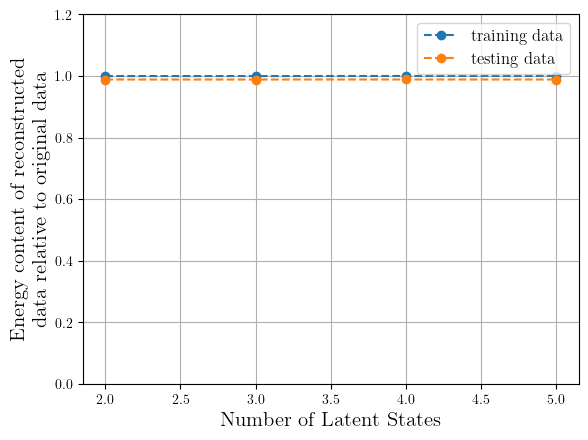

training data :  [0.99977318 0.99974792 1.0000425  1.00000048]
 testing data :  [0.98844665 0.98841855 0.98858263 0.98846716]


In [23]:
plt.plot(
    num_latent_states_list,
    np.sum(timeAvgEnergySpectrum[:, 0], axis=1)/np.sum(energySpectrum_og_trainingdata),
    '--', marker='o', label='training data')
plt.plot(
    num_latent_states_list,
    np.sum(timeAvgEnergySpectrum[:, 1], axis=1)/np.sum(energySpectrum_og_trainingdata),
    '--', marker='o', label='testing data')
plt.grid(True)
plt.xlabel('Number of Latent States', **xlabel_kwargs)
plt.ylabel('Energy content of reconstructed\ndata relative to original data', **xlabel_kwargs)
plt.ylim([0, 1.2])
plt.legend(**legend_kwargs)
plt.show()

print('training data : ', np.sum(timeAvgEnergySpectrum[:, 0], axis=1)/np.sum(energySpectrum_og_trainingdata))
print(' testing data : ', np.sum(timeAvgEnergySpectrum[:, 1], axis=1)/np.sum(energySpectrum_og_trainingdata))

100.0
100.0
100.0
100.0


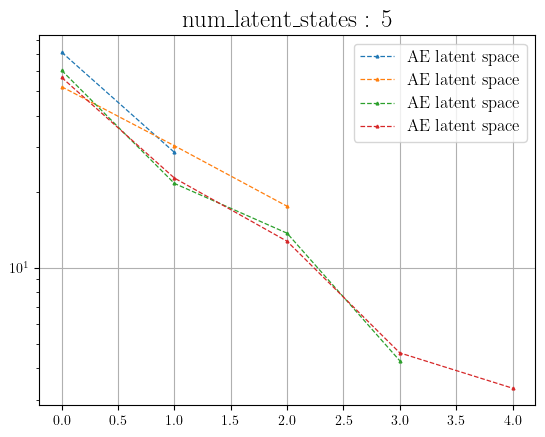

In [24]:
fig_eigvals, ax_eigvals = plt.subplots()
for i in range(len(chosen_dir_list)):
    # fig_eigvals, ax_eigvals = plt.subplots()
    # ax_eigvals.semilogy(eigvals_og/np.sum(eigvals_og), linestyle='--', marker='s', linewidth=0.9, markersize=2, label=r'Original Data')
    ax_eigvals.semilogy(
        100*latent_states_eigenvals_list[i][0]/np.sum(latent_states_eigenvals_list[i][0]),
        linestyle='--',
        marker='^',
        linewidth=0.9,
        markersize=2,
        label=r'AE latent space'
    )
    idx_end = 19
    if len(latent_states_eigenvals_list[i]) < idx_end:
        idx_end = len(latent_states_eigenvals_list[i][0])
    print(100*np.sum(latent_states_eigenvals_list[i][0][0:idx_end]/np.sum(latent_states_eigenvals_list[i][0])))
        
ax_eigvals.grid(True)
ax_eigvals.legend(**legend_kwargs)
ax_eigvals.set_axisbelow(True)
ax_eigvals.set_title('Eigenvalues of the covariance matrix', **title_kwargs)
plt.title('num_latent_states : {}'.format(num_latent_states_list[i]), **title_kwargs)
plt.show()

In [25]:
with open(dir_name_aepod+'/chosen_dirs.txt', 'w') as f:
    s = 'dir_name, num_latent_states\n'#, enc_filters, dec_filters/n'
    f.write(s)
    for i in range(len(chosen_dir_list)):
        s = chosen_dir_list[i] + ', ' + str(num_latent_states_list[i]) + '\n'
        # s += ', ' + str(attention_used_list[i]) + ', ' + str(latent_states_shape_list[i]) + '\n'
        f.write(s)

# POD

In [26]:
# podcentering_means = np.empty(shape=numpoints_xgrid)
# for i in range(numpoints_xgrid):
#     podcentering_means[i] = np.mean(all_data_og[:, i])
#     all_data_og[:, i] -= podcentering_means[i]
# cov_matrix = all_data_og[:, 0:xgrid.shape[0]].transpose() @ all_data_og[:, 0:xgrid.shape[0]]
# cov_matrix /= all_data_og.shape[0]-1

podcentering_means = np.mean(training_data[:, 0:og_vars], axis=0)
meancentereddata_og_trainingdata = training_data[:, 0:og_vars] - podcentering_means
cov_matrix = np.matmul(meancentereddata_og_trainingdata.transpose(), meancentereddata_og_trainingdata)
cov_matrix /= meancentereddata_og_trainingdata.shape[0] - 1

In [27]:
eigenvals, eigenvecs = linalg.eig(cov_matrix)
sorted_idx = np.argsort(eigenvals)
eigenvals = eigenvals[sorted_idx]
eigenvecs = eigenvecs[:, sorted_idx]

In [28]:
for i in range(len(eigenvals)):
    ev = eigenvals[i]
    if ev < 0.0:
        print(i, ev)
#         eigenvals[i] *= -1
#         eigenvecs[:, i] *= -1
#         print(i, ev)

In [29]:
# sorted_idx = np.argsort(eigenvals)
# eigenvals = eigenvals[sorted_idx]
# eigenvecs = eigenvecs[:, sorted_idx]

In [30]:
# print(eigenvals)

# for i in range(eigenvecs.shape[1]):
#     print('norm(ev[:, {}]) : {}'.format(i, np.sum(eigenvecs[:, i]**2)))

In [31]:
pod_timeAvgEnergySpectrum = []
covmat_list_pod = []
eigvals_list_pod = []
POD_recon_MSE_lst = []
POD_recon_RMSE_lst = []
POD_recon_NMSE_lst = []
POD_recon_NRMSE_lst = []

stddev_all_data = np.std(training_data[:, 0:og_vars], axis=0)

for num_latent_states in num_latent_states_list:
    # num_latent_states = num_latent_states_list[i]
    Wl = eigenvecs[:, -num_latent_states:]
    data = [training_data, testing_data]
    energySpectrum = []
    covmat_pod = []
    eigvals_pod = []
    reconstruction_MSE = []
    reconstruction_RMSE = []
    normalized_recon_MSE = []
    normalized_recon_RMSE = []
    for ii in range(len(data)):
        Xl = (data[ii][:, 0:og_vars]-podcentering_means) @ Wl @ Wl.transpose()
        for i in range(og_vars):
            Xl[:, i] += podcentering_means[i]
        FourierCoeffs = fft.fft(Xl, axis=1)
        energySpectrum.append(np.mean(FourierCoeffs.real**2 + FourierCoeffs.imag**2, axis=0))

        meancentereddata_pod = Xl[:, 0:og_vars] - np.mean(Xl[:, 0:og_vars], axis=0)
        covmat_pod.append(np.matmul(meancentereddata_pod.transpose(), meancentereddata_pod) / (meancentereddata_pod.shape[0] - 1))
        eigvals_pod.append(np.sort(np.abs(np.linalg.eigvals(covmat_pod[ii])))[::-1])
        # print(eigvals_pod[ii].shape, covmat_pod[ii].shape, Xl.shape)

        reconstruction_MSE_ii = (Xl[:, 0:og_vars] - data[ii][:, 0:og_vars])**2
        # stddev_all_data = np.std(all_data_og, axis=0)
        normalized_recon_MSE_ii = np.average(reconstruction_MSE_ii/stddev_all_data**2, axis=1)
        normalized_recon_RMSE.append(np.average(normalized_recon_MSE_ii**0.5, axis=0))
        normalized_recon_MSE.append(np.average(normalized_recon_MSE_ii, axis=0))
        reconstruction_MSE_ii = np.average(reconstruction_MSE_ii, axis=1)
        reconstruction_RMSE.append(np.average(reconstruction_MSE_ii**0.5, axis=0))
        reconstruction_MSE.append(np.average(reconstruction_MSE_ii, axis=0))

    pod_timeAvgEnergySpectrum.append(energySpectrum)
    covmat_list_pod.append(covmat_pod)
    eigvals_list_pod.append(eigvals_pod)
    POD_recon_MSE_lst.append(reconstruction_MSE)
    POD_recon_RMSE_lst.append(reconstruction_RMSE)
    POD_recon_NMSE_lst.append(normalized_recon_MSE)
    POD_recon_NRMSE_lst.append(normalized_recon_RMSE)

In [32]:
pod_timeAvgEnergySpectrum = np.array(pod_timeAvgEnergySpectrum)
covmat_list_pod = np.array(covmat_list_pod)
eigvals_list_pod = np.array(eigvals_list_pod)
POD_recon_MSE_lst = np.array(POD_recon_MSE_lst)
POD_recon_RMSE_lst = np.array(POD_recon_RMSE_lst)
POD_recon_NMSE_lst = np.array(POD_recon_NMSE_lst)
POD_recon_NRMSE_lst = np.array(POD_recon_NRMSE_lst)

# Comparison of Time Averaged RMSE

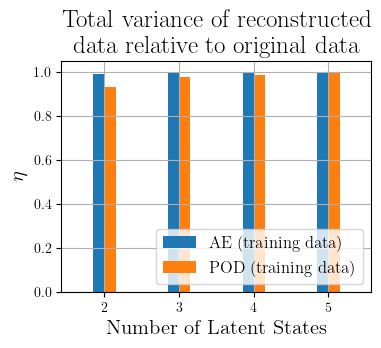

--trainingdata AE: [0.99296523 1.00006745 1.00009815 0.99948164]
--trainingdata POD: [0.93314206 0.97566673 0.98835272 0.99593177]



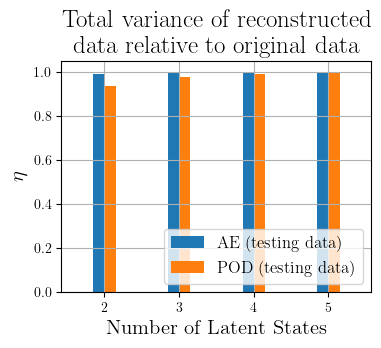

---testingdata AE: [0.99247658 0.99950031 0.99928624 0.9985272 ]
---testingdata POD: [0.933519   0.97603681 0.98853125 0.99586995]



In [33]:
width = 0.15
ind = np.arange(num_latent_states_list.shape[0])

legend_suffix = [' (training data)', ' (testing data)']
savename_suffix = ['--trainingdata', '---testingdata']

for ii in range(2):
    # plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
    # plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
    sum_ = np.sum(eigvals_og_trainingdata)
    if ii == 1:
        sum_ = np.sum(eigvals_og_testingdata)
    plt.bar(ind, np.sum(eigvals_list_AE[:, ii], axis=1)/sum_, width, label='AE'+legend_suffix[ii])
    plt.bar(ind+width, np.sum(eigvals_list_pod[:, ii], axis=1)/sum_, width, label='POD'+legend_suffix[ii])
    plt.grid(True)
    plt.xlabel('Number of Latent States', **xlabel_kwargs)
    # plt.ylabel('Energy content of reconstructed\ndata relative to original data', **ylabel_kwargs)
    # plt.ylabel(
    #     r'$ \sum_i \| \mathbf{x}(t_i) - \overline{\mathbf{x}} \|^2 \ / \ \sum_i \| \mathbf{x}^{i} - \overline{\mathbf{x}} \|^2$',
    #     **ylabel_kwargs
    # )
    plt.ylabel('$\eta$', **ylabel_kwargs)
    plt.title('Total variance of reconstructed\ndata relative to original data', **title_kwargs)
    plt.xticks(ind+width/2, [r''+str(elem) for elem in num_latent_states_list])
    # plt.ylim([-0.05, 1.05])
    plt.xlim(-0.5, ind[-1]+width+0.5)
    plt.legend(loc='lower right', **legend_kwargs)
    
    plt.gcf().set_size_inches(4,3)

    plt.savefig(dir_name_plot+'/energy_content_AE_POD'+savename_suffix[ii]+'.pdf', dpi=300, bbox_inches='tight')
    plt.show()

    # print('AE:', np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
    # print('POD:', np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og))
    print(savename_suffix[ii] + ' AE:', np.sum(eigvals_list_AE[:, ii], axis=1)/sum_)
    print(savename_suffix[ii] + ' POD:', np.sum(eigvals_list_pod[:, ii], axis=1)/sum_)
    print('')

    with open(dir_name_aepod+'/energy_content_AE_POD'+savename_suffix[ii]+'.txt', 'w') as f:
        s =  'num_latent_states : '
        temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
        s += ', '.join(temp_lst)
        s += "\n"
        s += '               AE : '
        temp_lst = ["{:.4E} %".format(100*elem) for elem in np.sum(eigvals_list_AE[:, ii], axis=1)/sum_]
        s += ', '.join(temp_lst)
        s += "\n"
        s += '              POD : '
        temp_lst = ["{:.4E} %".format(100*elem) for elem in np.sum(eigvals_list_pod[:, ii], axis=1)/sum_]
        s += ', '.join(temp_lst)
        s += "\n"
        f.write(s)

    plt.close()

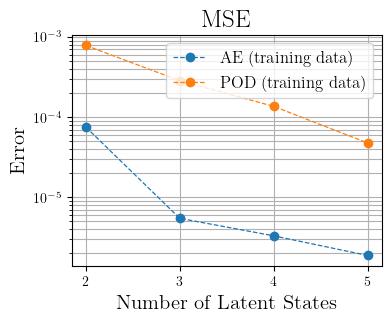

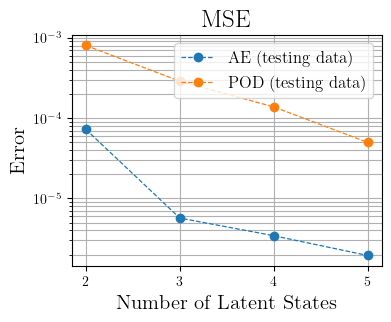

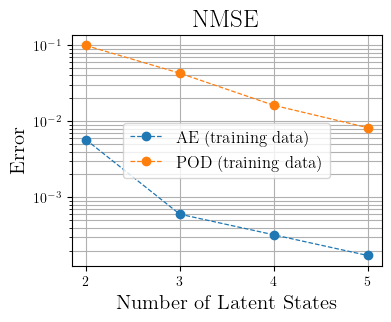

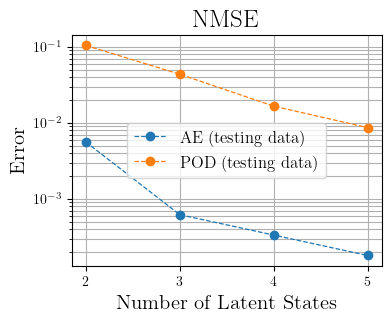

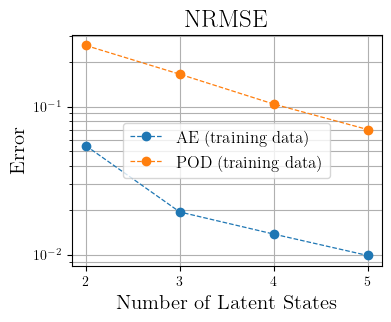

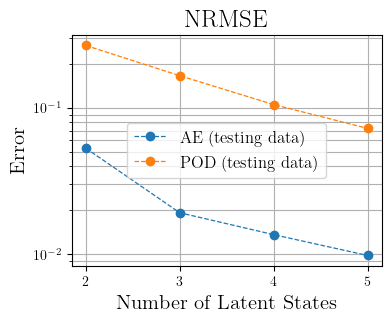

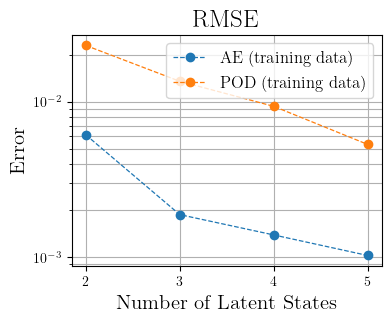

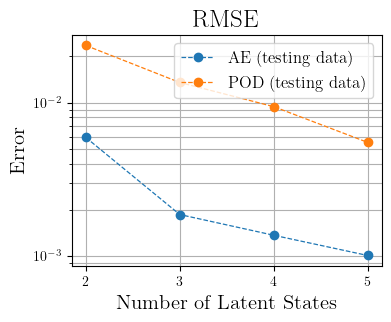

In [34]:
# reconstruction errors
error_type_list = ['MSE', 'NMSE', 'NRMSE', 'RMSE']
for jj in range(len(error_type_list)):
    error_type = error_type_list[jj]
    AE_error = eval('AE_recon_'+error_type+'_lst')
    POD_error = eval('POD_recon_'+error_type+'_lst')

    width = 0.15
    ind = np.arange(num_latent_states_list.shape[0])

    legend_suffix = [' (training data)', ' (testing data)']
    savename_suffix = ['--trainingdata', '---testingdata']
    for ii in range(2):
        # plt.bar(ind, np.sum(timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='AE')
        # plt.bar(ind+width, np.sum(pod_timeAvgEnergySpectrum, axis=1)/np.sum(energySpectrum_og), width, label='POD')
        plt.semilogy(num_latent_states_list, AE_error[:, ii], '--', marker='o', linewidth=0.9, label='AE'+legend_suffix[ii])
        plt.semilogy(num_latent_states_list, POD_error[:, ii], '--', marker='o', linewidth=0.9, label='POD'+legend_suffix[ii])
        plt.grid(True, which='both')
        plt.xlabel('Number of Latent States', **xlabel_kwargs)
        plt.ylabel('Error', **ylabel_kwargs)
        plt.title(error_type, **title_kwargs)
        plt.xticks(num_latent_states_list, [r''+str(elem) for elem in num_latent_states_list])
        # plt.ylim([-0.05, 1.05])
        # plt.xlim(-0.5, ind[-1]+width+0.5)
        plt.legend(**legend_kwargs)#loc='lower right')

        plt.gcf().set_size_inches(4,3)

        plt.savefig(dir_name_plot+'/AE_POD_'+error_type+savename_suffix[ii]+'.pdf', dpi=300, bbox_inches='tight')
        plt.show()

        with open(dir_name_aepod+'/AE_POD_'+error_type+savename_suffix[ii]+'.txt', 'w') as f:
            s =  'num_latent_states : '
            temp_lst = ["{:02d}".format(elem) for elem in num_latent_states_list]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '               AE : '
            temp_lst = ["{:.4E}".format(elem) for elem in AE_error[:, ii]]
            s += ', '.join(temp_lst)
            s += "\n"
            s += '              POD : '
            temp_lst = ["{:.4E}".format(elem) for elem in POD_error[:, ii]]
            s += ', '.join(temp_lst)
            s += "\n"
            f.write(s)
        plt.close()

In [35]:
k = fft.fftfreq(og_vars, d=1/og_vars)
idx = np.where(k<0)[0]
k[idx] += og_vars
print(k)#*numpoints_xgrid*2*np.pi/xgrid[-1])

[0. 1. 2. 3. 4. 5.]


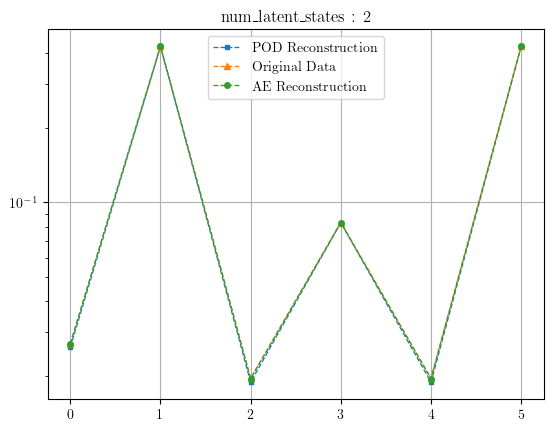

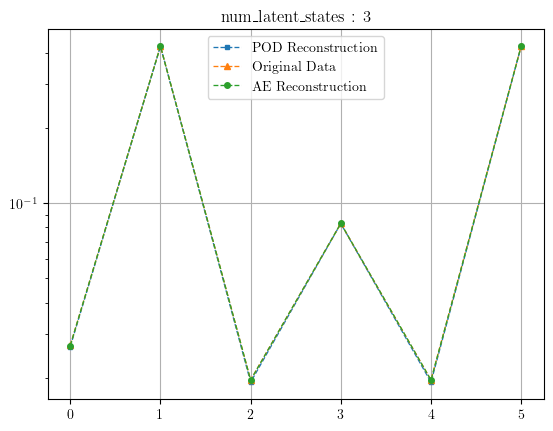

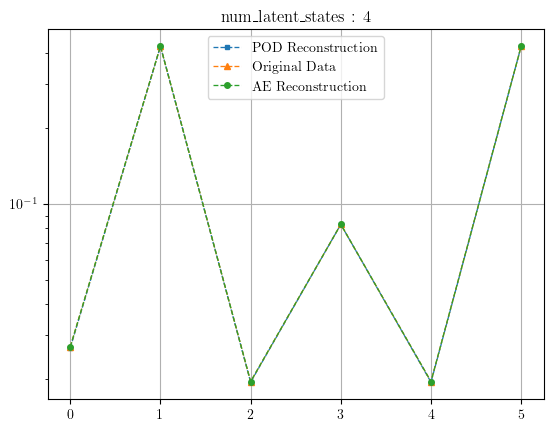

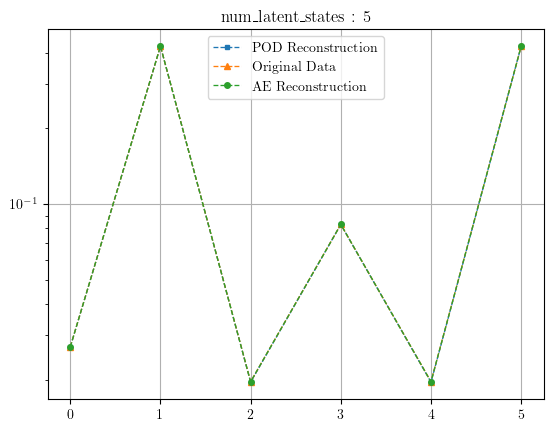

In [36]:
y1 = energySpectrum_og_trainingdata/np.sum(energySpectrum_og_trainingdata)
for i in range(len(chosen_dir_list)):
    y2 = timeAvgEnergySpectrum[i, 0]/np.sum(energySpectrum_og_trainingdata)# np.sum(timeAvgEnergySpectrum[i])
    y3 = pod_timeAvgEnergySpectrum[i, 0]/np.sum(energySpectrum_og_trainingdata)# np.sum(pod_timeAvgEnergySpectrum[i])
    plt.semilogy(k, y3, marker='s', markersize=3, linewidth=0.95, linestyle='--', label='POD Reconstruction')
    plt.semilogy(k, y1, marker='^', markersize=4, linewidth=0.95, linestyle='--', label='Original Data')
    plt.semilogy(k, y2, marker='o', markersize=4, linewidth=0.95, linestyle='--', label='AE Reconstruction')
    plt.title('num_latent_states : {}'.format(num_latent_states_list[i]))
    plt.grid(True)
    plt.legend()
    plt.show()

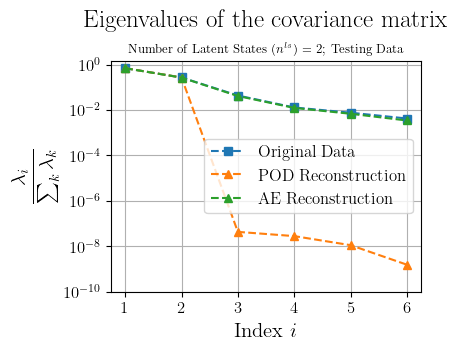

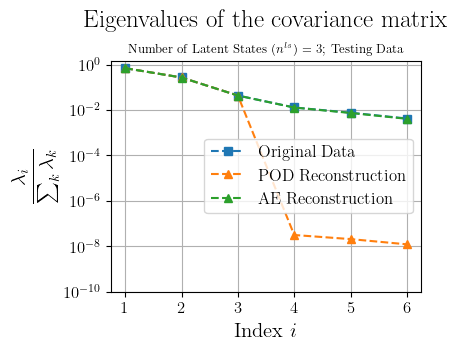

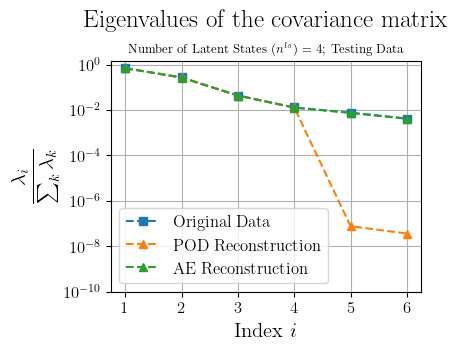

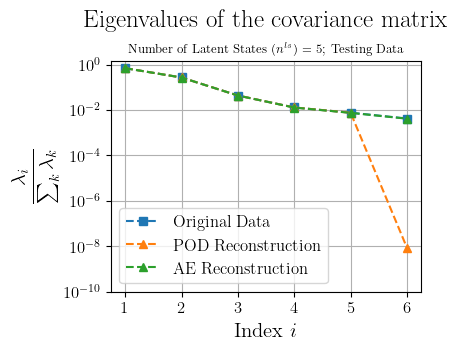

In [37]:
for i in range(len(chosen_dir_list)):
    fig_eigvals, ax_eigvals = plt.subplots()
    ev_sum = np.sum(eigvals_og_trainingdata)
    xplot = np.arange(1, eigvals_og_trainingdata.shape[0]+1)
    ax_eigvals.semilogy(
        xplot,
        eigvals_og_testingdata/ev_sum,
        linestyle='--',
        marker='s',
#         linewidth=0.9,
#         markersize=2,
    )
    ax_eigvals.semilogy(
        xplot,
        eigvals_list_pod[i, 1]/ev_sum,
        linestyle='--',
        marker='^',
#         linewidth=0.9,
#         markersize=2,
    )
    ax_eigvals.semilogy(
        xplot,
        eigvals_list_AE[i, 1]/ev_sum,
        linestyle='--',
        marker='^',
#         linewidth=0.9,
#         markersize=2,
    )
    ax_eigvals.grid(True)
    ax_eigvals.legend([r'Original Data', r'POD Reconstruction', r'AE Reconstruction'], **legend_kwargs)
    ax_eigvals.set_axisbelow(True)
    ax_eigvals.set_title('Eigenvalues of the covariance matrix\n'+r'\small{Number of Latent States $(n^{ls})$ = '+'{}'.format(num_latent_states_list[i])+r'; Testing Data}', **title_kwargs)
    ax_eigvals.set_ylabel(r'$$\frac{\lambda_i}{\sum_k \lambda_k}$$', **ylabel_kwargs)
#     ax_eigvals.set_ylabel(r'$$\lambda_i / \left( \sum_k \lambda_k \right)$$', **ylabel_kwargs)
    ax_eigvals.set_xlabel(r'Index $i$', **xlabel_kwargs)
    # plt.title(r'Number of Latent States $(n^{ls})$ = '+'{}'.format(num_latent_states_list[i]))
    ax_eigvals.set_ylim(1e-10, 1.5)
    plt.xticks(**legend_kwargs)
    plt.yticks(**legend_kwargs)
    
    plt.gcf().set_size_inches(4,3)
    
    plt.savefig(dir_name_plot+'/covmat_eigvals_testingdata_nls{:02d}.pdf'.format(num_latent_states_list[i]), bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    
    with open(dir_name_plot+'/covmat_eigvals_testingdata_nls{:02d}.txt'.format(num_latent_states_list[i]), 'w') as f:
        s =  'number of latent states : {:02d}\n'.format(num_latent_states_list[i])
        s += '\n POD \n'
        s +=   '-----\n'
        s += ', '.join(['{:.4E}'.format(elem) for elem in eigvals_list_pod[i, 1]/ev_sum])
        s += '\n  AE \n'
        s +=   '-----\n'
        s += ', '.join(['{:.4E}'.format(elem) for elem in eigvals_og_testingdata/ev_sum])
        f.write(s)

In [37]:
cmap_im = 'bwr'
cmap_error = 'viridis'

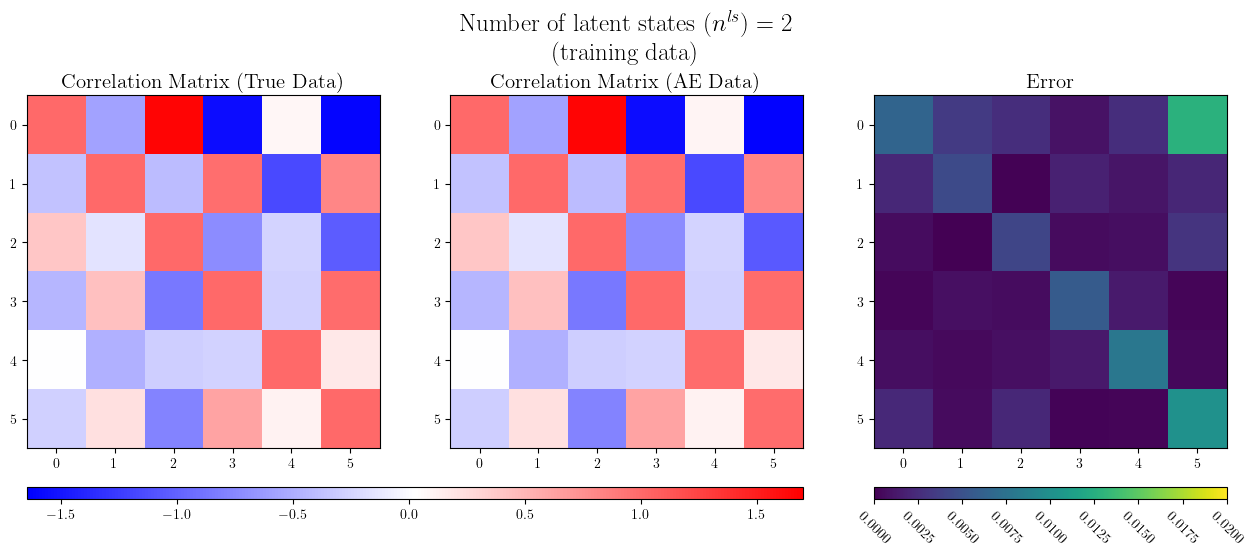

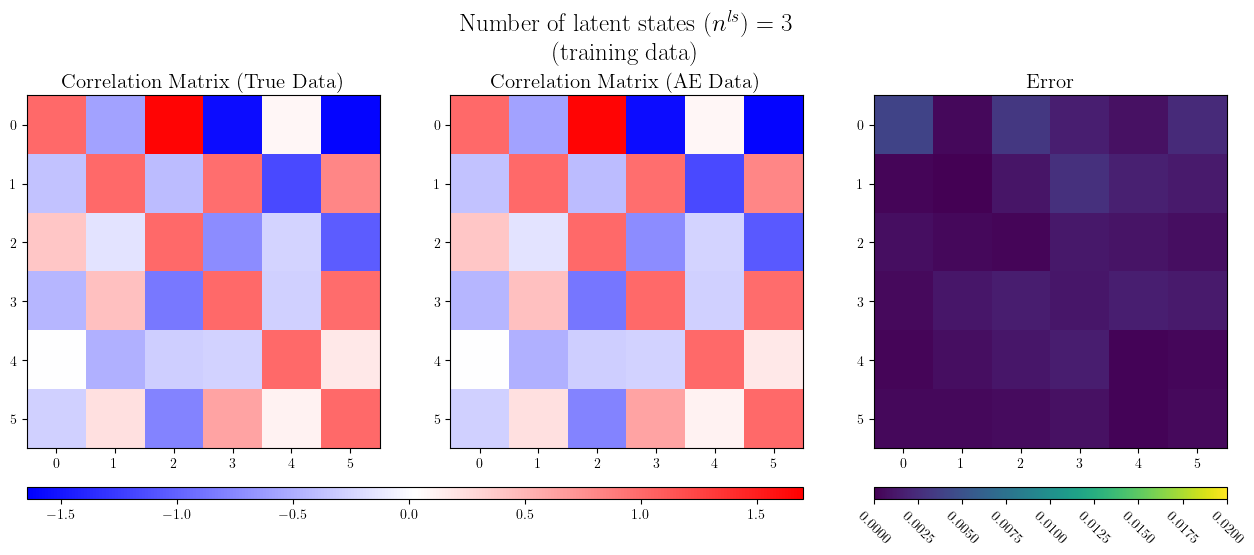

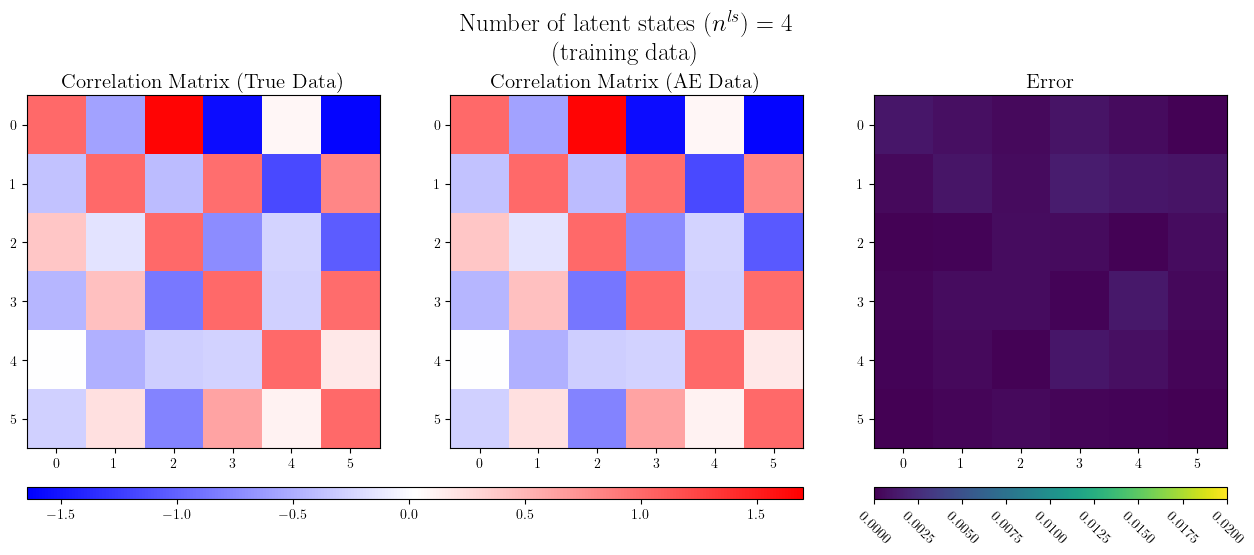

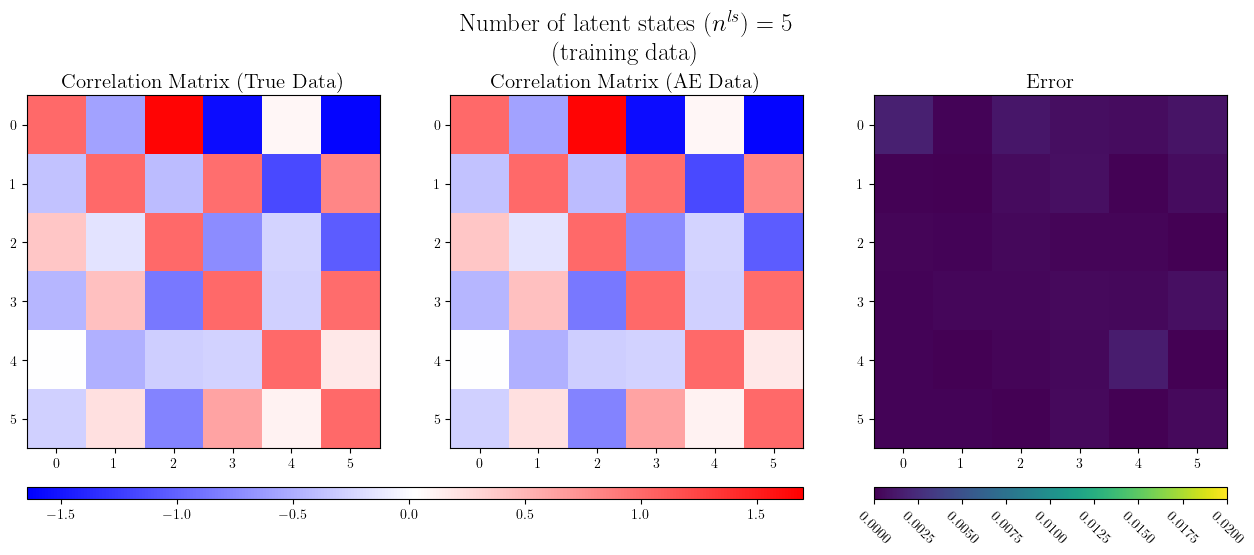

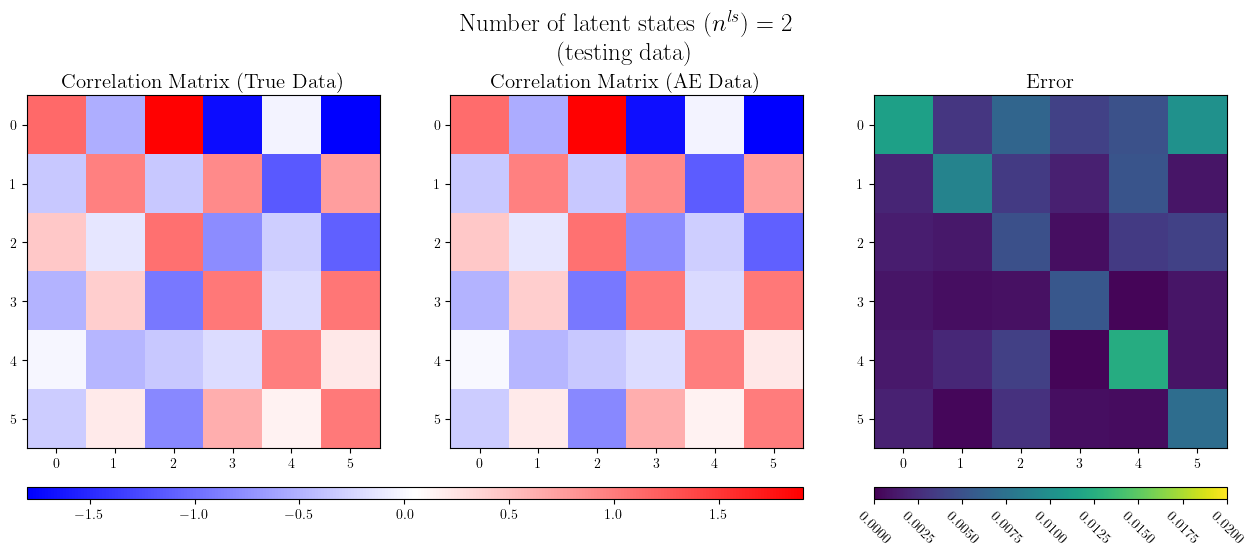

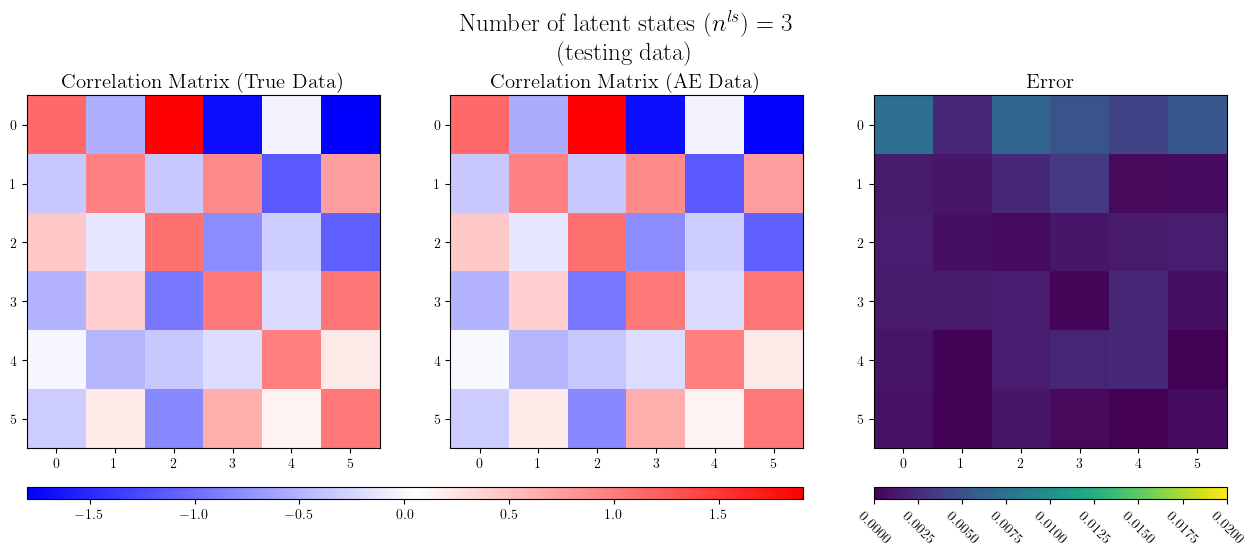

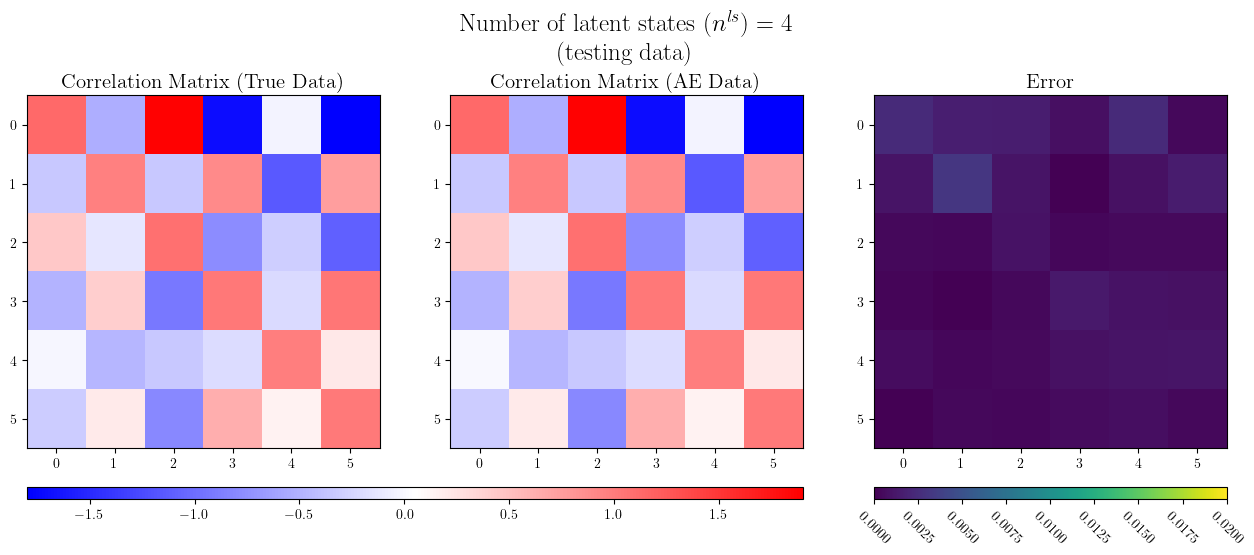

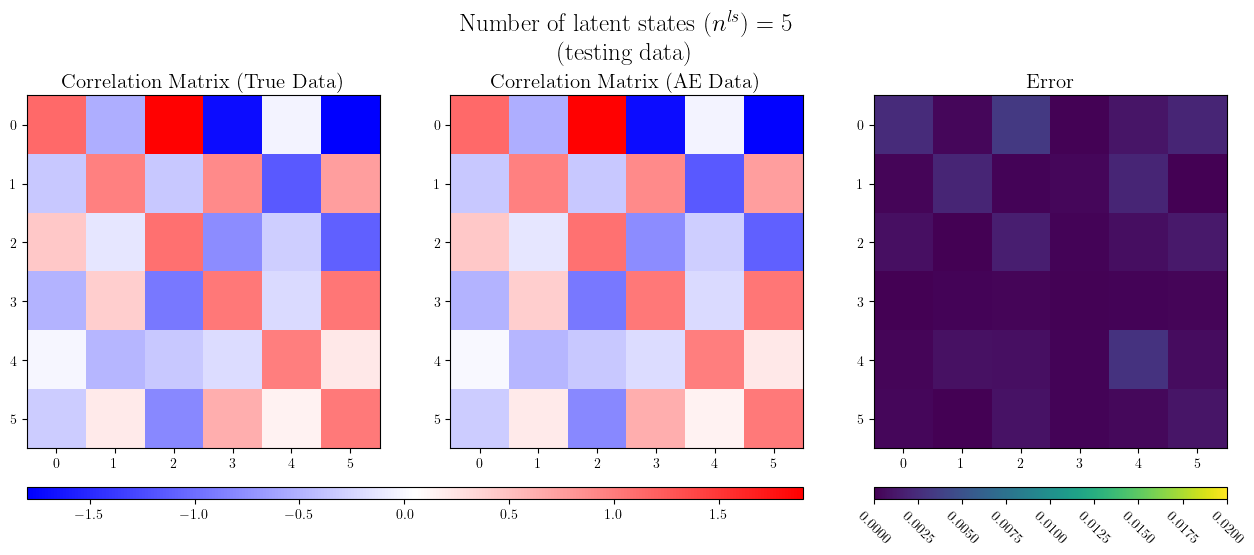

In [38]:
legend_suffix = [r'(training data)', r'(testing data)']
savename_suffix = ['--trainingdata', '---testingdata']
for ii in range(2):
    if ii == 0:
        covmat_og_normd = np.divide(np.transpose(covmat_og_trainingdata), np.diag(covmat_og_trainingdata)).transpose()
    elif ii == 1:
        covmat_og_normd = np.divide(np.transpose(covmat_og_testingdata), np.diag(covmat_og_trainingdata)).transpose()
    for i in range(len(chosen_dir_list)):
        fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
        subplot1 = 1
        subplot2 = subplot1 + 1

        covmat_ae_normd = np.divide(np.transpose(covmat_list_AE[i, ii]), np.diag(covmat_og_trainingdata)).transpose()

        vmin_snap = 0.05
        vmax_snap = 0.05
        vmin = np.min([
            covmat_og_normd.min(),
            covmat_ae_normd.min()
        ])
        vmin = min(vmin, -1.0)
        vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
        vmax = np.max([
            covmat_og_normd.max(),
            covmat_ae_normd.max()
        ])
        vmax = max(vmax, 1.0)
        vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

        # plotting the original data
        ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
        im_orig = ax_covmat_orig.imshow(
            covmat_og_normd,
            aspect='equal',
            origin='upper',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap_im,
        )
        ax_covmat_orig.set_title('Correlation Matrix (True Data)', **xlabel_kwargs)
        # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        # ax_covmat_orig.set_xticks(ticks=xticks)
        # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
        # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
        # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
        # ax_covmat_orig.set_yticks(ticks=yticks)
        # ax_covmat_orig.set_yticklabels(yticklabels)
        # ax_covmat_orig.set_xlabel(xlabel)
        # ax_covmat_orig.set_ylabel(ylabel)

        # plotting the predicted data
        ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
        im_predict = ax_covmat_predict.imshow(
            covmat_ae_normd,
            aspect='equal',
            origin='upper',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap_im,
        )
        ax_covmat_predict.set_title('Correlation Matrix (AE Data)', **xlabel_kwargs)
        # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
        # ax_covmat_predict.set_xlabel(xlabel)
        # ax_covmat_predict.set_ylabel(ylabel)

        # subplots adjustment to account for colorbars
        fig_covmat.subplots_adjust(
            bottom=0.1,
            left=0.1,
            top=1.0-0.19,
        )

        # original data and recon data colorbar
        cb_xbegin = ax_covmat_orig.transData.transform([-0.5, 0])
        cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
        cb_xend = ax_covmat_predict.transData.transform([covmat_ae_normd.shape[-1]-0.5, 0])
        cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

        cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
        cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

        # computing the normalized error
        subplot3 = subplot2+1
        error = np.abs(covmat_og_normd-covmat_ae_normd)
        vmax_error_snap = 0.02
        vmax_error = np.max(error)
        vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
        # error = 100*error / np.abs(pod_covmat_dataout)
        # plotting the normalized error
        ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
        im_error = ax_covmat_error.imshow(
            error,
            aspect='equal',
            origin='upper',
            vmin=0.0,
            vmax=vmax_error,
            cmap=cmap_error,
        )
        ax_covmat_error.set_title(r'Error', **xlabel_kwargs)
        # ax_error.tick_params(axis='x', rotation=270+45)
        # ax_error.set_xlabel(xlabel)
        # ax_error.set_ylabel(ylabel)

        # error colorbar
        cbe_xbegin = ax_covmat_error.transData.transform([-0.5, 0])
        cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
        cbe_xend = ax_covmat_error.transData.transform([covmat_ae_normd.shape[-1]-0.5, 0])
        cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
        error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
        error_cb_ax.tick_params(axis='x', rotation=270+45)
        cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')

        fig_covmat.suptitle(
            r' Number of latent states $(n^{ls}) = ' + str(num_latent_states_list[i]) + '$\n' + legend_suffix[ii],
            **title_kwargs
        )

        plt.savefig(dir_name_plot+'/covmat_error_AE_nls{}'.format(num_latent_states_list[i])+savename_suffix[ii]+'.pdf', bbox_inches='tight', dpi=300)
        plt.show()

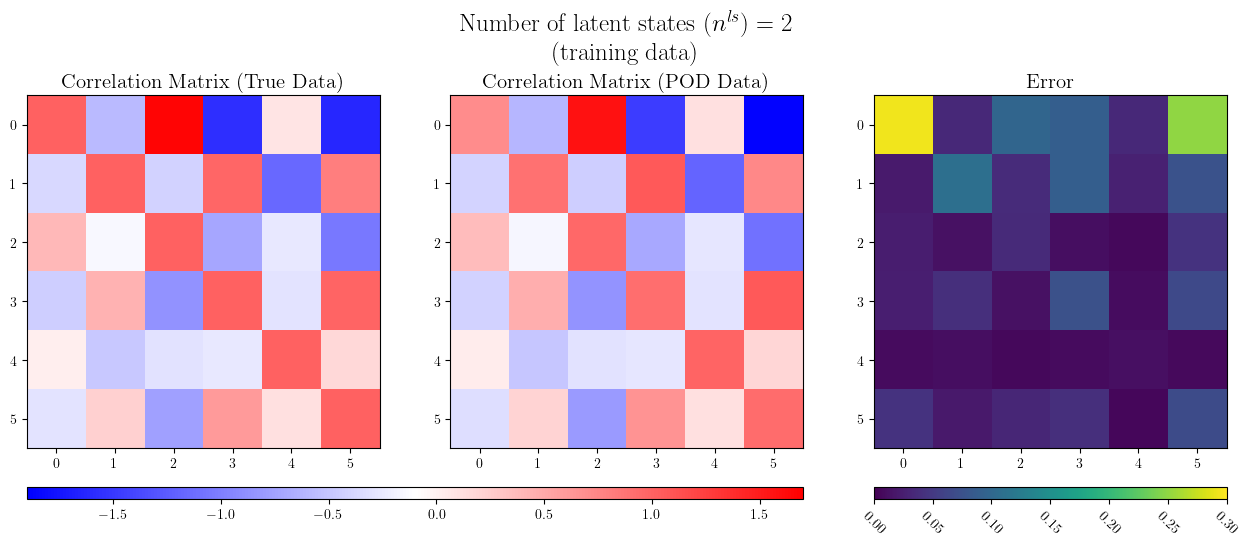

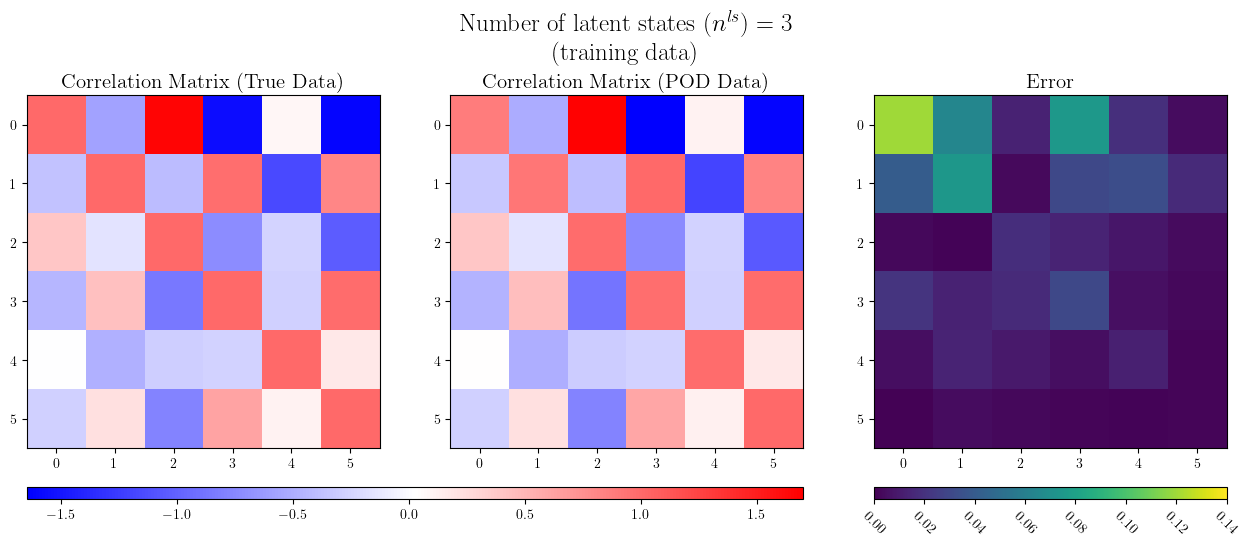

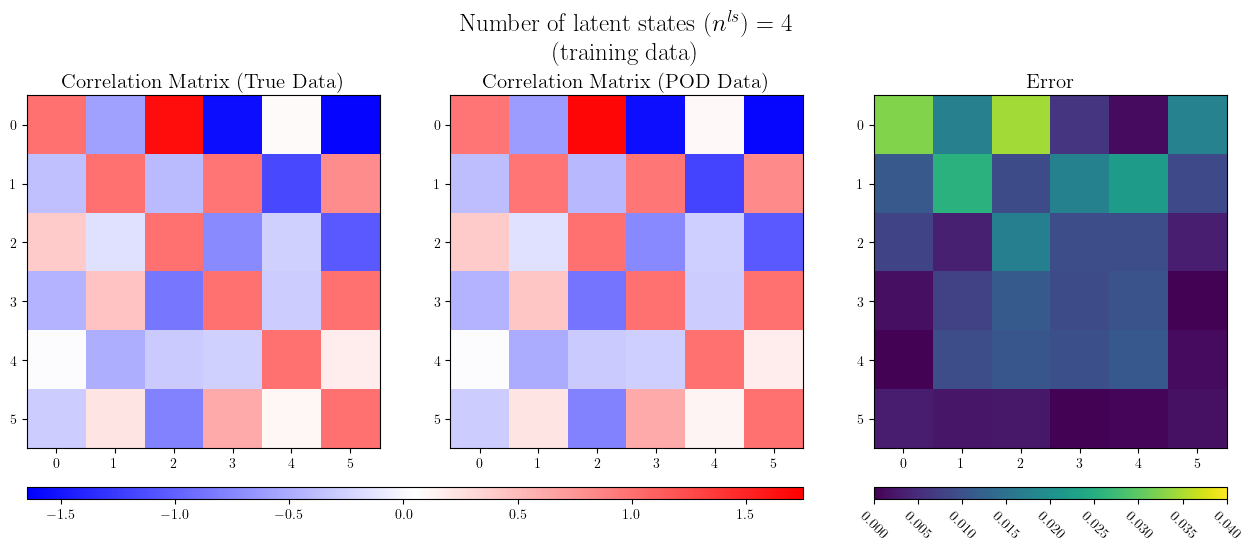

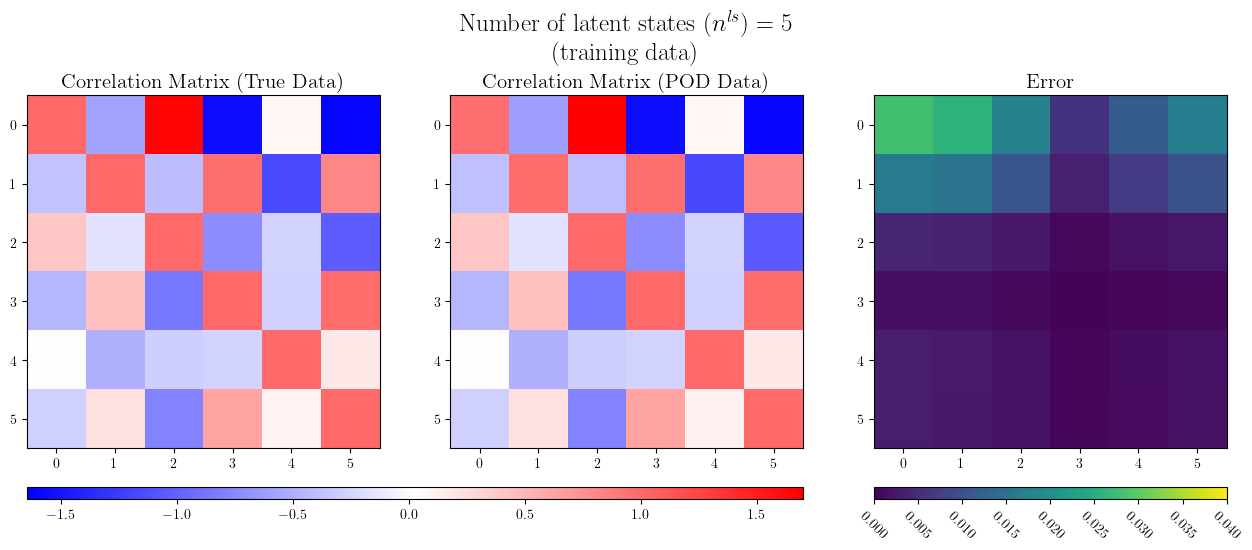

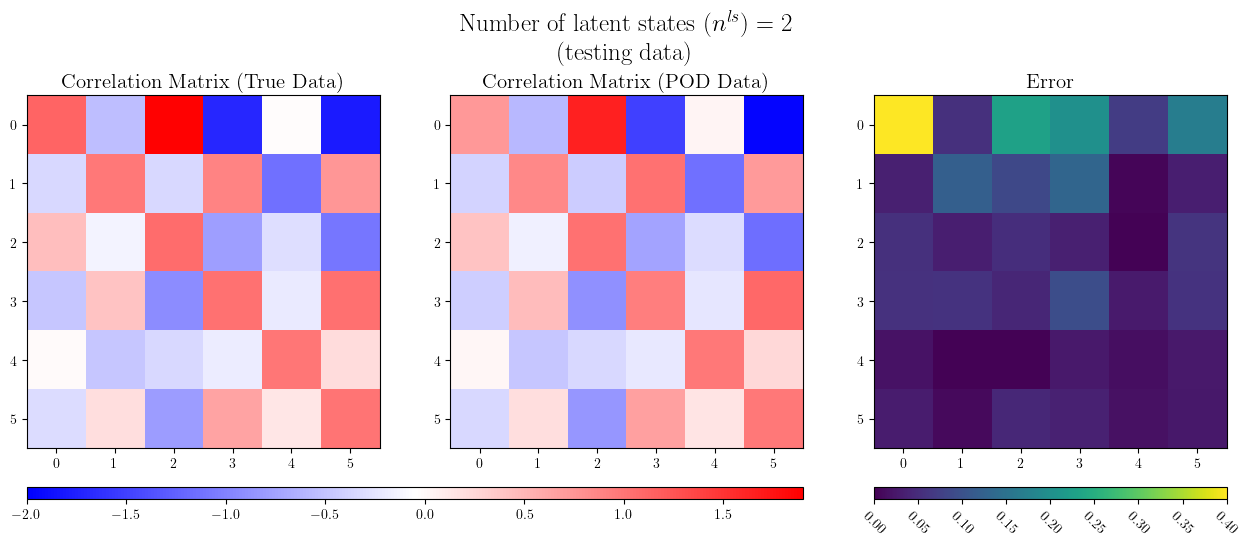

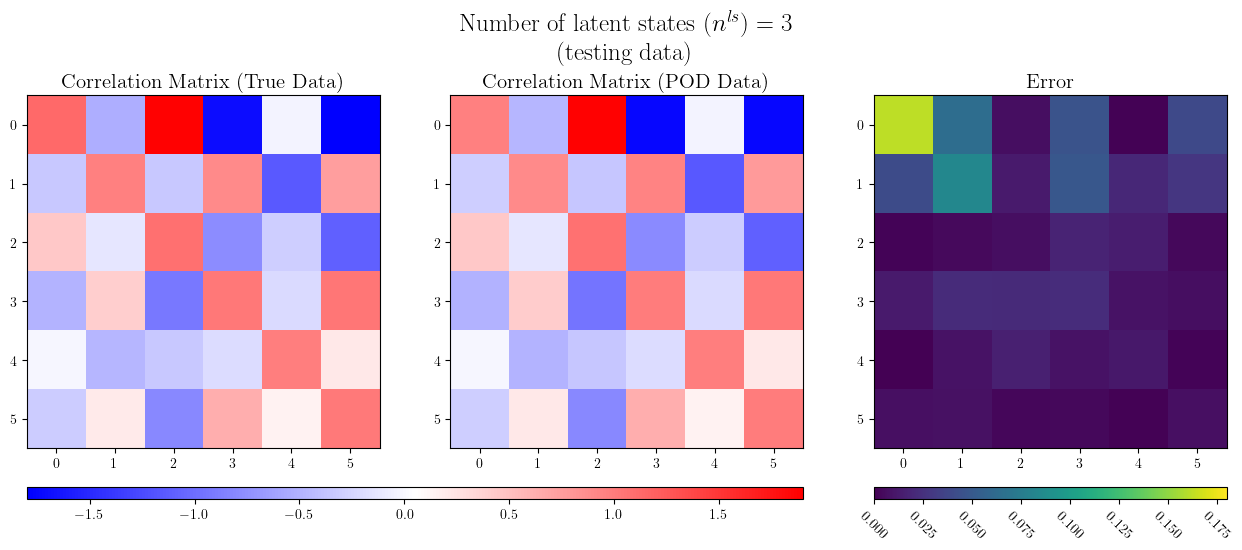

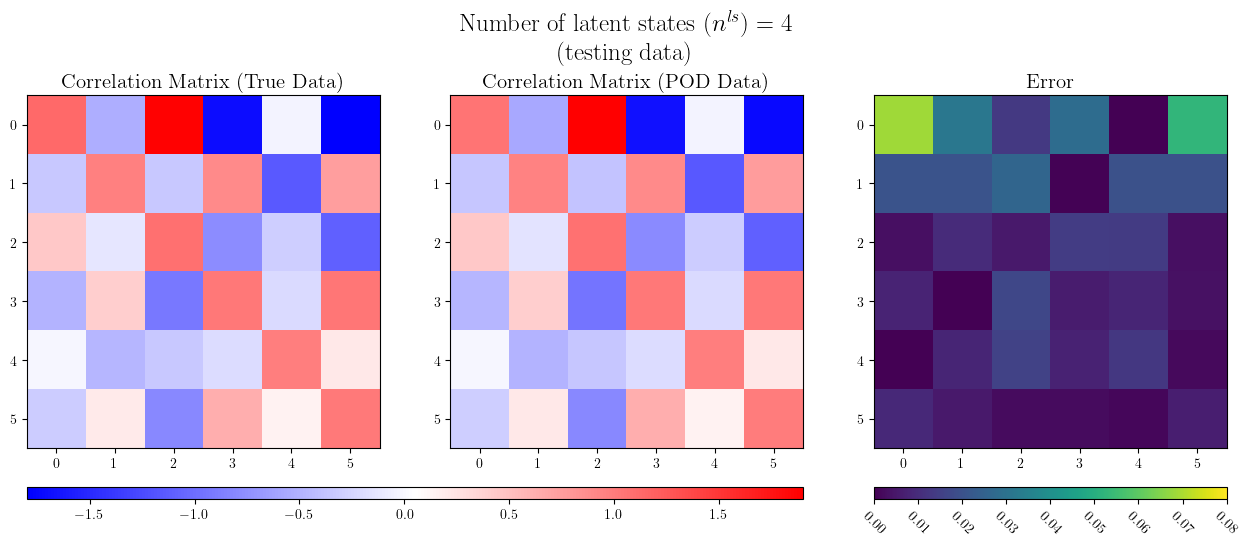

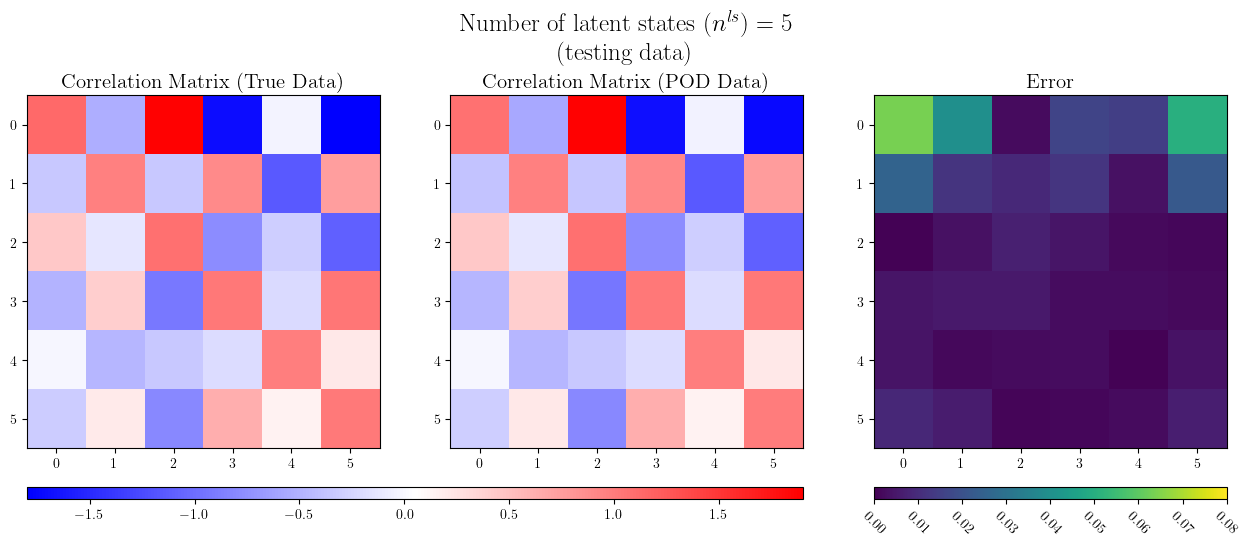

In [39]:
legend_suffix = [r'(training data)', r'(testing data)']
savename_suffix = ['--trainingdata', '---testingdata']
for ii in range(2):
    if ii == 0:
        covmat_og_normd = np.divide(np.transpose(covmat_og_trainingdata), np.diag(covmat_og_trainingdata)).transpose()
    elif ii == 1:
        covmat_og_normd = np.divide(np.transpose(covmat_og_testingdata), np.diag(covmat_og_trainingdata)).transpose()
    for i in range(len(chosen_dir_list)):
        fig_covmat = plt.figure(figsize=(5.0*3, 5.0*1))
        subplot1 = 1
        subplot2 = subplot1 + 1

        covmat_pod_normd = np.divide(np.transpose(covmat_list_pod[i, ii]), np.diag(covmat_og_trainingdata)).transpose()

        vmin_snap = 0.05
        vmax_snap = 0.05
        vmin = np.min([
            covmat_og_normd.min(),
            covmat_pod_normd.min()
        ])
        vmin = min(vmin, -1.0)
        vmin = -vmin_snap*np.round(-vmin/vmin_snap + 0.5)
        vmax = np.max([
            covmat_og_normd.max(),
            covmat_pod_normd.max()
        ])
        vmax = max(vmax, 1.0)
        vmax = vmax_snap*np.round(vmax/vmax_snap + 0.5)

        # plotting the original data
        ax_covmat_orig = fig_covmat.add_subplot(1, 3, subplot1)
        im_orig = ax_covmat_orig.imshow(
            covmat_og_normd,
            aspect='equal',
            origin='upper',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap_im,
        )
        ax_covmat_orig.set_title('Correlation Matrix (True Data)', **xlabel_kwargs)
        # xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        # ax_covmat_orig.set_xticks(ticks=xticks)
        # ax_covmat_orig.set_xticklabels(np.round(xticks*delta_t, 1))
        # ax_covmat_orig.tick_params(axis='x', rotation=270+45)
        # yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        # yticklabels = np.round(xgrid[0]+np.linspace(0, 1, yticks.shape[0])*(xgrid[-1]-xgrid[0]), 2)
        # ax_covmat_orig.set_yticks(ticks=yticks)
        # ax_covmat_orig.set_yticklabels(yticklabels)
        # ax_covmat_orig.set_xlabel(xlabel)
        # ax_covmat_orig.set_ylabel(ylabel)

        # plotting the predicted data
        ax_covmat_predict = fig_covmat.add_subplot(1, 3, subplot2, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
        im_predict = ax_covmat_predict.imshow(
            covmat_pod_normd,
            aspect='equal',
            origin='upper',
            vmin=vmin,
            vmax=vmax,
            cmap=cmap_im,
        )
        ax_covmat_predict.set_title('Correlation Matrix (POD Data)', **xlabel_kwargs)
        # ax_covmat_predict.tick_params(axis='x', rotation=270+45)
        # ax_covmat_predict.set_xlabel(xlabel)
        # ax_covmat_predict.set_ylabel(ylabel)

        # subplots adjustment to account for colorbars
        fig_covmat.subplots_adjust(
            bottom=0.1,
            left=0.1,
            top=1.0-0.19,
        )

        # original data and recon data colorbar
        cb_xbegin = ax_covmat_orig.transData.transform([-0.5, 0])
        cb_xbegin = fig_covmat.transFigure.inverted().transform(cb_xbegin)[0]
        cb_xend = ax_covmat_predict.transData.transform([covmat_pod_normd.shape[-1]-0.5, 0])
        cb_xend = fig_covmat.transFigure.inverted().transform(cb_xend)[0]

        cb_ax = fig_covmat.add_axes([cb_xbegin, 0.0, cb_xend-cb_xbegin, 0.025])
        cbar = fig_covmat.colorbar(im_predict, cax=cb_ax, orientation='horizontal')

        # computing the normalized error
        subplot3 = subplot2+1
        error = np.abs(covmat_og_normd-covmat_pod_normd)
        vmax_error_snap = 0.02
        vmax_error = np.max(error)
        vmax_error = vmax_error_snap*np.round(vmax_error/vmax_error_snap + 0.5)
        # error = 100*error / np.abs(pod_covmat_dataout)
        # plotting the normalized error
        ax_covmat_error = fig_covmat.add_subplot(1, 3, subplot3, sharey=ax_covmat_orig, sharex=ax_covmat_orig)
        im_error = ax_covmat_error.imshow(
            error,
            aspect='equal',
            origin='upper',
            vmin=0.0,
            vmax=vmax_error,
            cmap=cmap_error,
        )
        ax_covmat_error.set_title(r'Error', **xlabel_kwargs)
        # ax_error.tick_params(axis='x', rotation=270+45)
        # ax_error.set_xlabel(xlabel)
        # ax_error.set_ylabel(ylabel)

        # error colorbar
        cbe_xbegin = ax_covmat_error.transData.transform([-0.5, 0])
        cbe_xbegin = fig_covmat.transFigure.inverted().transform(cbe_xbegin)[0]
        cbe_xend = ax_covmat_error.transData.transform([covmat_pod_normd.shape[-1]-0.5, 0])
        cbe_xend = fig_covmat.transFigure.inverted().transform(cbe_xend)[0]
        error_cb_ax = fig_covmat.add_axes([cbe_xbegin, 0.0, cbe_xend-cbe_xbegin, 0.025])
        error_cb_ax.tick_params(axis='x', rotation=270+45)
        cbar_error = fig_covmat.colorbar(im_error, cax=error_cb_ax, orientation='horizontal')

        fig_covmat.suptitle(
            r' Number of latent states $(n^{ls}) = ' + str(num_latent_states_list[i]) + '$\n' + legend_suffix[ii],
            **title_kwargs
        )

        plt.savefig(dir_name_plot+'/covmat_error_POD_nls{}'.format(num_latent_states_list[i])+savename_suffix[ii]+'.pdf', bbox_inches='tight', dpi=300)
        plt.show()